# Gate calibration with RL with the Quantum Orchestration Platform

This notebook is the template workflow enabling you to run gate calibration leveraging all the low-level capabilities of the QOP for maximum efficiency.

In [1]:
import numpy as np
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, Gate
from typing import List
from gymnasium.spaces import Box
from rl_qoc.qua import QMEnvironment, QMConfig, CustomQMPPO
from quam_libs.components import QuAM, Transmon
from qiskit_qm_provider import FluxTunableTransmonBackend, QMInstructionProperties, InputType
from qiskit_qm_provider.backend import add_basic_macros_to_machine
from rl_qoc.agent.ppo_config import (
    WandBConfig,
    PPOConfig,
    TrainingConfig,
    TrainFunctionSettings,
    TotalUpdates,
)
from rl_qoc import (
    RescaleAndClipAction,
    ChannelReward,
    StateReward,
    CAFEReward,
    ExecutionConfig,
    QEnvConfig,
    BenchmarkConfig,
    GateTarget,
    StateTarget,
)

2025-07-14 17:11:19,241 - qm - INFO     - Starting session: aea88de3-ce95-4fce-b3d0-ef7c0acd0e3f
2025-07-14 17:11:19 INFO Starting session: aea88de3-ce95-4fce-b3d0-ef7c0acd0e3f


/Users/arthurostrauss/Library/CloudStorage/OneDrive-QMMachinesLTD/GitHub/qiskit-qm-provider/qiskit_qm_provider/backend/backend_utils.py:17: UserWarning: get_control_flow_name_mapping is not available in this version of Qiskit, skipping it from control flow mapping.
  warnings.warn(


## Accessing the device

Here, we fetch the latest calibration data from one of the IQCC available devices. For now, the two available ones are Gilboa ("gilboa") and Arbel ("arbel").

In [2]:
from iqcc_cloud_client import IQCC_Cloud
import json
import os
from pathlib import Path

# Set your quantum computer backend
path = Path.home() / "iqcc_token.json"
with open(path, "r") as f:
    iqcc_config = json.load(f)

quantum_computer_backend = "gilboa"  # for example qc_qwfix
iqcc = IQCC_Cloud(
    quantum_computer_backend=quantum_computer_backend,
    api_token=iqcc_config[quantum_computer_backend],
)
# Get the latest state and wiring files
latest_wiring = iqcc.state.get_latest("wiring")
latest_state = iqcc.state.get_latest("state")

# Get the state folder path from environment variable
quam_state_folder_path = os.environ["QUAM_STATE_PATH"]

# Save the files
with open(os.path.join(quam_state_folder_path, "wiring.json"), "w") as f:
    json.dump(latest_wiring.data, f, indent=4)

with open(os.path.join(quam_state_folder_path, "state.json"), "w") as f:
    json.dump(latest_state.data, f, indent=4)

In [3]:
iqcc.summary()

Backend:         gilboa

Status:          🟢 online

Description:     21-qubit superconducting processor featuring flux-tunable transmons with fixed coupling 
architecture

                  Available state information                  
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ datatype          ┃ description                             ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ state             │ state used for the Quam object          │
│ wiring            │ wiring used for the Quam object         │
│ chipview_png      │ base64 encoded png image of chip layout │
│ transpiler_target │ Qiskit transpiler target information    │
└───────────────────┴─────────────────────────────────────────┘

👉 Get latest data as 
 <backand_client>.state.get_latest("<datatype>").data

👉 Latest calibration (state): 2 weeks ago (2025-06-29 18:18:43.296651+00:00)

                                           Available on-demand workflows                                           
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ workflow     ┃ description                                                                                      ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ openqasm2qua │ Compilation of OpenQASM3 program to QUA, assuming that transpilation is done (physical qubit     │
│              │ allocation is done, and native gate set is used)                                                 │
└──────────────┴──────────────────────────────────────────────────────────────────────────────────────────────────┘

👉 Obtain more information about payload specification for each workflow as
<backand_client>.run("<workflow>")

👉 Run on-demand workflow as 
<backand_client>.run("<workflow>", payload)

                                              Supported native gates                                               
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃    Gate ┃ Qubits                         ┃ Error                             ┃ Duration                         ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       x │ 0, 1, 2, 3, 4, 5               │ 0.0007, 0.0017, 0.0009, 0.0012,   │ 48, 48, 48, 48, 48, 48           │
│         │                                │ 0.0008, 0.0013                    │                                  │
│      cz │ [1, 0], [2, 3], [4, 3], [5, 3] │ 0.99, 0.99, 0.99, 0.99            │ 40, 40, 40, 40                   │
│      rz │ 0, 1, 2, 3, 4, 5               │ None, None, None, None, None,     │ 4, 4, 4, 4, 4, 4                 │
│         │                                │ None                              │                                  │
│      sx │ 0, 1, 2, 3, 4, 5               │ 0.0007, 0.0017, 0.0009, 0.0012,   │ 48, 48, 48, 48, 48, 48           │
│         │                                │ 0.0008, 0.0013                    │                                  │
│   delay │ 0, 1, 2, 3, 4, 5               │ None, None, None, None, None,     │ 4, 4, 4, 4, 4, 4                 │
│         │                                │ None                              │                                  │
│   reset │ 0, 1, 2, 3, 4, 5               │ None, None, None, None, None,     │ 161076, 73320, 142176, 141884,   │
│         │                                │ None                              │ 189160, 174132                   │
│ measure │ 0, 1, 2, 3, 4, 5               │ 0.0353, 0.0577, 0.0403, 0.0543,   │ None, None, None, None, None,    │
│         │                                │ 0.0232, 0.0973                    │ None                             │
└─────────┴────────────────────────────────┴───────────────────────────────────┴──────────────────────────────────┘

{'hooks': {'pre': {'schema': {}},
  'post': {'schema': {}},
  'sync': {'schema': {}}},
 'state': {'state': {'description': 'state used for the Quam object'},
  'wiring': {'description': 'wiring used for the Quam object'},
  'chipview_png': {'description': 'base64 encoded png image of chip layout'},
  'transpiler_target': {'description': 'Qiskit transpiler target information'}},
 'online': True,
 'runtime': {'visa': {}},
 'ondemand': {'openqasm2qua': {'schema': {'type': 'object',
    'required': ['openqasm3', 'num_shots'],
    'properties': {'num_shots': {'type': 'integer',
      'description': 'number of repetitions of the circuit execution'},
     'openqasm3': {'type': 'string',
      'description': 'OpenQASM3 code as string'}},
    'additionalProperties': False},
   'description': 'Compilation of OpenQASM3 program to QUA, assuming that transpilation is done (physical qubit allocation is done, and native gate set is used)'}},
 'description': '21-qubit superconducting processor featuri

## Creating a Qiskit Backend interface from Quam.

We have created a powerful Qiskit to QUA compiler that can enable the compilation (and execution) of almost all Qiskit QuantumCircuits, as long as they are transpiled against the backend object created from the Quam that we define below.

In [4]:
machine = QuAM.load()

add_basic_macros_to_machine(machine)
backend = FluxTunableTransmonBackend(machine, name=quantum_computer_backend)
backend.set_options(timeout=100)
print(backend.target)

Target: Transmon based QuAM
Number of qubits: 4
Instructions:
	x
		(0,):
			Duration: 4.8e-08 sec.
		(1,):
			Duration: 4.8e-08 sec.
		(2,):
			Duration: 4.8e-08 sec.
		(3,):
			Duration: 4.8e-08 sec.
	rz
		(0,):
			Duration: 0 sec.
			Error Rate: 0
		(1,):
			Duration: 0 sec.
			Error Rate: 0
		(2,):
			Duration: 0 sec.
			Error Rate: 0
		(3,):
			Duration: 0 sec.
			Error Rate: 0
	sx
		(0,):
			Duration: 4.8e-08 sec.
		(1,):
			Duration: 4.8e-08 sec.
		(2,):
			Duration: 4.8e-08 sec.
		(3,):
			Duration: 4.8e-08 sec.
	delay
		(0,):
		(1,):
		(2,):
		(3,):
	reset
		(0,):
			Duration: 0.00017258 sec.
		(1,):
			Duration: 0.000144824 sec.
		(2,):
			Duration: 0.000174564 sec.
		(3,):
			Duration: 0.00018182 sec.
	measure
		(0,):
			Duration: 1.65e-06 sec.
		(1,):
			Duration: 1.65e-06 sec.
		(2,):
			Duration: 1.65e-06 sec.
		(3,):
			Duration: 1.65e-06 sec.
	sy
		(0,):
			Duration: 4.8e-08 sec.
		(1,):
			Duration: 4.8e-08 sec.
		(2,):
			Duration: 4.8e-08 sec.
		(3,):
			Duration: 4.8

/Users/arthurostrauss/Library/CloudStorage/OneDrive-QMMachinesLTD/GitHub/qiskit-qm-provider/qiskit_qm_provider/backend/backend_utils.py:215: UserWarning: Could not add default two qubit gates. Add it manually if necessary.
  warnings.warn("Could not add default two qubit gates. Add it manually if necessary.")


In [5]:
print(backend.options)

Options(shots=1024, compiler_options=None, simulate=None, memory=False, skip_reset=False, meas_level=<MeasLevel.CLASSIFIED: 2>, meas_return=<MeasReturnType.AVERAGE: 'avg'>, timeout=100)


In [6]:
print("Available qubits: ", backend.qubit_dict)
print("Available qubit pairs: ", backend.qubit_pair_dict)

Available qubits:  {'qC5': 0, 'qD1': 1, 'qD2': 2, 'qD3': 3}
Available qubit pairs:  {'qD1-qD2': (2, 1)}


In [7]:
using_vpn = True
if using_vpn:
    machine.network["cloud"] = False
    machine.network["port"] = 9510
else:
    backend.qmm = iqcc

In [8]:
machine.network

{'host': '10.1.1.6', 'port': 9510, 'cloud': False, 'octave_ips': [], 'cluster_name': 'galil_gilboa', 'octave_ports': [], 'quantum_computer_backend': 'gilboa'}

## Create a custom gate to edit

We add at the Qiskit level the custom gate we want to calibrate, and we then specify the QUA macro in charge of 
implementing the parametrized pulse representation of this template parametrized gate.

The way we specify such gate is by implementing a function (think about a Pennylane qnode), that modifies an input QuantumCircuit, and adds a custom Gate of your choice that is parametrized in a certain fashion.
The choice of the parametrization is defined by the action space specification (see below), and the shape of the QUA macro you decide to insert as a physical implementation of your gate. 
For now, parametrization is constrained to parameters that can be used to update the pulses in real-time, e.g. amplitude, phase, frequency, duration. For more advanced composite pulses, we can also think about baking some precomposite pulses, that could then be passed as keyword arguments to the parametrized circuit function.

In [9]:
from rl_qoc.helpers import add_custom_gate

def apply_parametrized_circuit(
    qc: QuantumCircuit, params: List[Parameter], q_reg: QuantumRegister, **kwargs
):

    physical_qubits: List[int] = kwargs["physical_qubits"]
    backend: FluxTunableTransmonBackend = kwargs["backend"]

    # TODO: Enter your custom parametric QUA macro here
    def qua_macro(amp):
        qubit: Transmon = backend.get_qubit(physical_qubits[0])
        qubit.xy.play("x180", amplitude_scale=amp)

    # Create a custom gate with the QUA macro
    custom_x = Gate("x_cal", 1, params)
    x_duration = backend.target["x"][(physical_qubits[0],)].duration
    instruction_prop = QMInstructionProperties(duration=x_duration,qua_pulse_macro=qua_macro)
    qc = add_custom_gate(
        qc,
        custom_x,
        q_reg,
        params,
        physical_qubits,
        backend,
        instruction_prop
    )
    return qc

## Create Environment configuration

1. Create target instance: Specify which gate you want and on which qubit it should be applied
2. Choose which reward scheme you want. You can choose among three methods that are carefully implemented within the QOP: Direct Channel/State Fidelity Estimation (DFE), and Context-Aware Fidelity Estimation (CAFE)

In [10]:
physical_qubits = (0,)
target_gate = "x"
target_state = "1"
# We show the two possible targets:
# 1. A gate target, i.e. a gate that we want to calibrate
gate_target = GateTarget(physical_qubits=physical_qubits, gate=target_gate)
# 2. A state target, i.e. a state that we want to reach
state_target = StateTarget(state=target_state, physical_qubits=physical_qubits)
# Choose the target
target = gate_target
# Initialize the reward scheme to be used in the environment
reward = ChannelReward()

In [11]:
"""
It is possible to define custom reward methods, by inheriting from the Reward class. 
The two main methods to implement are:
- get_reward_data: this method is called to generate the necessary data to pass to the OPX to compute the reward (e.g., observables, input states)
- rl_qoc_training_qua_prog: this method is called to generate the QUA program that will be executed on the device to compute the reward.
- qm_step: this method is called to compute the reward for a given epoch.
"""
from rl_qoc.qua.pi_pulse_reward import PiPulseReward
# reward = PiPulseReward()




3. Decide which action space to create
4. Decide how the parameters should be passed to the QOP (Choose between Input Stream, DGX Quantum, IO variables)
5. To fix the QUA program duration, we also can pass to the configuration the number of training updates expected (it should be the same variable used when declaring the agent).
6. Set up training hyperparameters on the environment side

In [12]:
# Action space specification
param_bounds = [(-1.98, 2.0)]  # Can be any number of bounds


# Environment execution parameters
seed = 98  # Master seed to make training reproducible
batch_size = 8*4  # Number of actions to evaluate per policy evaluation
n_shots = 50 # Minimum number of shots per fiducial evaluation
pauli_sampling = 50  # Number of fiducials to compute for fidelity estimation (DFE only)
n_reps = [1]  # Number of repetitions of the cycle circuit
num_updates = TotalUpdates(100)

input_type = InputType.INPUT_STREAM
test_mode = True


def create_action_space(param_bounds):
    param_bounds = np.array(param_bounds, dtype=np.float32)
    lower_bound, upper_bound = param_bounds.T
    return Box(low=lower_bound, high=upper_bound, shape=(len(param_bounds),), dtype=np.float32)


action_space = create_action_space(param_bounds)

backend_config = QMConfig(
    parametrized_circuit=apply_parametrized_circuit,
    backend=backend,
    input_type=input_type,
    verbosity=2,
    parametrized_circuit_kwargs={"physical_qubits": physical_qubits, "backend": backend},
    num_updates=num_updates.total_updates,
    timeout=40,
    test_mode=test_mode,
)
execution_config = ExecutionConfig(
    batch_size=batch_size,
    sampling_paulis=pauli_sampling,
    n_shots=n_shots,
    n_reps=n_reps,
    seed=seed,
)
q_env_config = QEnvConfig(
    target=target,
    backend_config=backend_config,
    action_space=action_space,
    execution_config=execution_config,
    reward=reward,
    benchmark_config=BenchmarkConfig(0),
)  # No benchmark for now

q_env = QMEnvironment(training_config=q_env_config)
rescaled_env = RescaleAndClipAction(q_env, np.float32(-1.0), np.float32(1.0))

In [13]:
machine.active_qubits[0].macros["measure"]

MeasureMacro(id='measure', fidelity=None, duration=1.65e-06, pulse=SquareReadoutPulse(length=1500, id=None, digital_marker='ON', amplitude=0.09623293583011833, axis_angle=None, threshold=0.0008489900824199183, rus_exit_threshold=0.0006683296698917661, integration_weights=[(1, 1500)], integration_weights_angle=-52.48462371050496))

In [14]:
print(backend.target)

Target: Transmon based QuAM
Number of qubits: 4
Instructions:
	x
		(0,):
			Duration: 4.8e-08 sec.
		(1,):
			Duration: 4.8e-08 sec.
		(2,):
			Duration: 4.8e-08 sec.
		(3,):
			Duration: 4.8e-08 sec.
	rz
		(0,):
			Duration: 0 sec.
			Error Rate: 0
		(1,):
			Duration: 0 sec.
			Error Rate: 0
		(2,):
			Duration: 0 sec.
			Error Rate: 0
		(3,):
			Duration: 0 sec.
			Error Rate: 0
	sx
		(0,):
			Duration: 4.8e-08 sec.
		(1,):
			Duration: 4.8e-08 sec.
		(2,):
			Duration: 4.8e-08 sec.
		(3,):
			Duration: 4.8e-08 sec.
	delay
		(0,):
		(1,):
		(2,):
		(3,):
	reset
		(0,):
			Duration: 0.00017258 sec.
		(1,):
			Duration: 0.000144824 sec.
		(2,):
			Duration: 0.000174564 sec.
		(3,):
			Duration: 0.00018182 sec.
	measure
		(0,):
			Duration: 1.65e-06 sec.
		(1,):
			Duration: 1.65e-06 sec.
		(2,):
			Duration: 1.65e-06 sec.
		(3,):
			Duration: 1.65e-06 sec.
	sy
		(0,):
			Duration: 4.8e-08 sec.
		(1,):
			Duration: 4.8e-08 sec.
		(2,):
			Duration: 4.8e-08 sec.
		(3,):
			Duration: 4.8

In [15]:
from qiskit_qm_provider import InputType
q_env.config.as_dict()

{'target': {'gate': 'x', 'physical_qubits': (0,)},
 'backend_config': {'input_type': 'INPUT_STREAM',
  'verbosity': 2,
  'num_updates': 100,
  'opnic_dev_path': '/home/dpoulos/opnic-dev'},
 'action_space': {'low': [-1.9800000190734863], 'high': [2.0]},
 'execution_config': {'batch_size': 32,
  'sampling_paulis': 50,
  'n_shots': 50,
  'n_reps': [1],
  'c_factor': 1.0,
  'seed': 98},
 'reward_config': 'channel',
 'benchmark_config': {'benchmark_cycle': 0,
  'benchmark_batch_size': 1,
  'tomography_analysis': 'default',
  'check_on_exp': False},
 'metadata': {}}

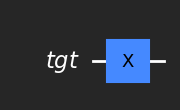

In [16]:
q_env.baseline_circuit.draw("mpl", style="iqp-dark", fold=20)

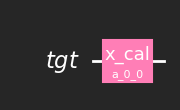

In [17]:
q_env.circuit.draw("mpl", style="iqp-dark", fold=20)

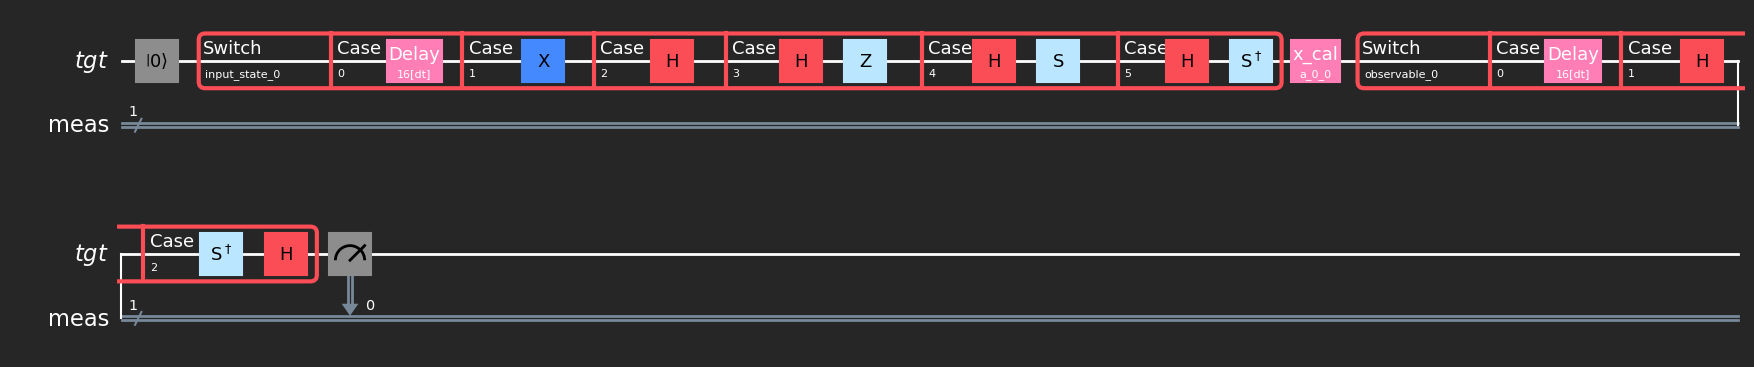

In [18]:
q_env.real_time_circuit.draw("mpl", style="iqp-dark", fold=25)

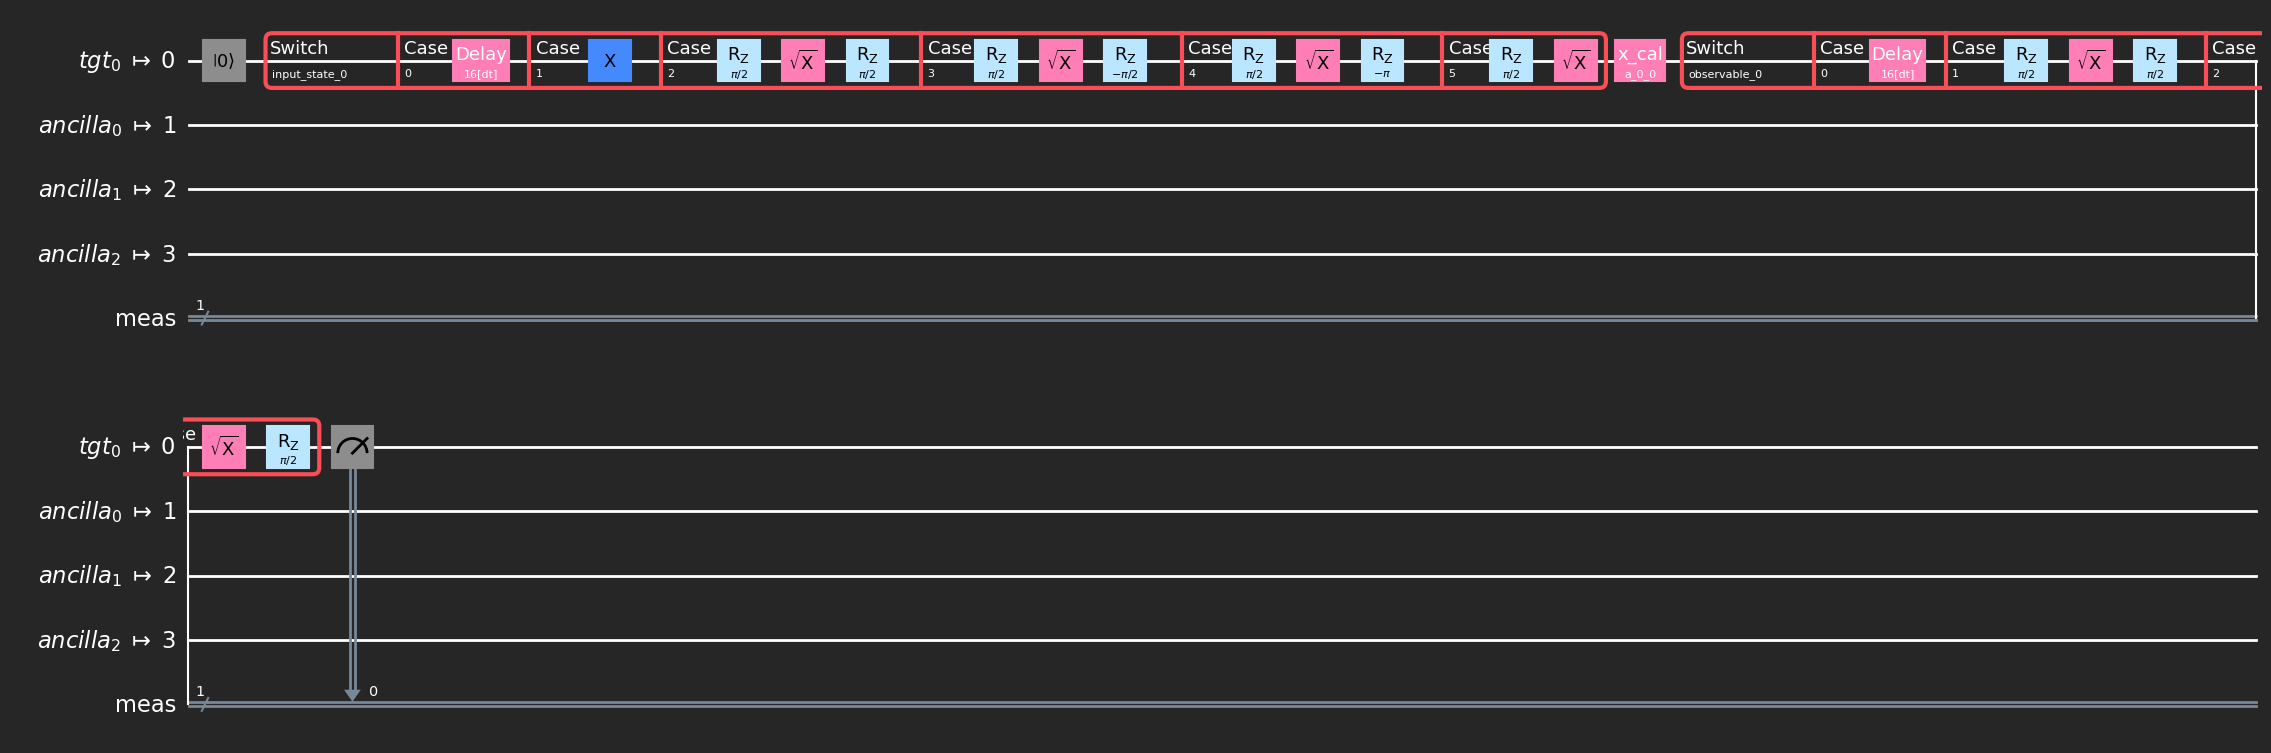

In [19]:
q_env.real_time_transpiled_circuit.draw("mpl", fold=32, style="iqp-dark")

In [20]:
# Print the OpenQASM3 program
print(backend.oq3_exporter.dumps(q_env.real_time_transpiled_circuit))

OPENQASM 3.0;
input float[64] a_0_0;
input uint[4] observable_0;
input uint[8] input_state_0;
bit[1] meas;
int switch_dummy;
int switch_dummy_0;
reset $0;
switch_dummy = input_state_0;
switch (switch_dummy) {
  case 0 {
    delay[16dt] $0;
  }
  case 1 {
    x $0;
  }
  case 2 {
    rz(1.5707963267948966) $0;
    sx $0;
    rz(1.5707963267948966) $0;
  }
  case 3 {
    rz(1.5707963267948966) $0;
    sx $0;
    rz(-1.570796326794897) $0;
  }
  case 4 {
    rz(1.5707963267948966) $0;
    sx $0;
    rz(-3.141592653589793) $0;
  }
  case 5 {
    rz(1.5707963267948966) $0;
    sx $0;
  }
}
x_cal(a_0_0) $0;
switch_dummy_0 = observable_0;
switch (switch_dummy_0) {
  case 0 {
    delay[16dt] $0;
  }
  case 1 {
    rz(1.5707963267948966) $0;
    sx $0;
    rz(1.5707963267948966) $0;
  }
  case 2 {
    sx $0;
    rz(1.5707963267948966) $0;
  }
}
meas[0] = measure $0;



In [21]:
from qm import generate_qua_script
# Print the QUA program
print(generate_qua_script(q_env.rl_qoc_training_qua_prog(num_updates.total_updates)))


# Single QUA script generated at 2025-07-14 17:11:31.114242
# QUA library version: 1.2.2

from qm import CompilerOptionArguments
from qm.qua import *

with program() as prog:
    input_stream_input_state_0 = declare_input_stream(int, 'input_state_0', value=0)
    input_stream_observable_0 = declare_input_stream(int, 'observable_0', value=0)
    input_stream_pauli_shots = declare_input_stream(int, 'pauli_shots', value=50)
    input_stream_max_input_state = declare_input_stream(int, 'max_input_state', value=1)
    input_stream_max_observables = declare_input_stream(int, 'max_observables', value=0)
    v1 = declare(fixed, value=0.0)
    input_stream_mu = declare_input_stream(fixed, 'mu', value=[0.0])
    input_stream_sigma = declare_input_stream(fixed, 'sigma', value=[1.0])
    a1 = declare(int, value=[0, 0])
    v2 = declare(int, )
    v3 = declare(int, )
    v4 = declare(int, )
    v5 = declare(int, )
    v6 = declare(int, )
    v7 = declare(int, value=0)
    v8 = declare(int, )
    v9

In [22]:
reward.get_reward_data(
    q_env.circuit, np.zeros((q_env.batch_size, q_env.n_actions)), q_env.target, q_env.config
)

ChannelRewardDataList([ChannelRewardData(pub=EstimatorPub(<(32,)>), input_circuit=<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x3098dc450>, observables=SparsePauliOp(['X'],
              coeffs=[-6.5+0.j]), n_reps=1, causal_cone_qubits_indices=[0], input_pauli=Pauli('X'), input_indices=(np.int64(3),), observables_indices=[(1,)]), ChannelRewardData(pub=EstimatorPub(<(32,)>), input_circuit=<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x30b3d7fd0>, observables=SparsePauliOp(['X'],
              coeffs=[6.5+0.j]), n_reps=1, causal_cone_qubits_indices=[0], input_pauli=Pauli('X'), input_indices=(np.int64(2),), observables_indices=[(1,)]), ChannelRewardData(pub=EstimatorPub(<(32,)>), input_circuit=<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x30c2d6710>, observables=SparsePauliOp(['Y'],
              coeffs=[6.-0.j]), n_reps=1, causal_cone_qubits_indices=[0], input_pauli=Pauli('Y'), input_indices=(np.int64(5),), observables_indices=[(2,)]), ChannelRewardData

# Defining the Agent and launching training

To push efficiency, we have introduced a custom version of the PPO algorithm whose particularity is that the sampling of the actions is in fact replicating a sampling mechanism done in real-time within the OPX. This way, we can through seed sharing share the actions between the two entities without having to introduce any communication latency to perform training.

In [23]:
ppo_config = PPOConfig.from_yaml("agent_config.yaml")
ppo_agent = CustomQMPPO(ppo_config, rescaled_env)
ppo_training = TrainingConfig(num_updates)
ppo_settings = TrainFunctionSettings(plot_real_time=True, print_debug=True, num_prints=10)

In [24]:
running_jobs = backend.qmm.get_jobs(status="Running")
print(running_jobs)

2025-07-14 17:11:33,398 - qm - INFO     - Performing health check
2025-07-14 17:11:33 INFO Performing health check
2025-07-14 17:11:34,286 - qm - INFO     - Cluster healthcheck completed successfully.
2025-07-14 17:11:34 INFO Cluster healthcheck completed successfully.
[]


In [25]:
running_jobs = backend.qmm.get_jobs(status="Running")
print(running_jobs)
if not running_jobs:
    q_env.clear_history()
    job = q_env.start_program()


[]


/Users/arthurostrauss/Library/CloudStorage/OneDrive-QMMachinesLTD/GitHub/quam/quam/components/channels.py:647: UserWarning: The 'thread' element argument is deprecated from qm.qua >= 1.2.2. Use 'core' instead.
  warnings.warn(


2025-07-14 17:11:43,271 - qm - INFO     - Clearing queue
2025-07-14 17:11:43 INFO Clearing queue
2025-07-14 17:11:44,585 - qm - INFO     - Adding program to queue.
2025-07-14 17:11:44 INFO Adding program to queue.


In [31]:
job.halt()

/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_13534/2760244435.py:1: DeprecationWarning: job.halt is deprecated since "1.2.0" and will be removed in "1.4.0". This method was renamed to `job.cancel`.
  job.halt()


True

In [28]:
q_env.std_action = np.array([0.01], dtype=np.float32)
reward = []
q_env.step_tracker = 0
q_env.clear_history()
for action in np.linspace(-1.0, 1.0, 20):
    q_env.mean_action = rescaled_env.action(np.array([action], dtype=np.float32))
    print(q_env.step(np.array([action], dtype=np.float32))[1])
    reward.append(q_env.reward_history[-1])
    q_env.step_tracker += 1

Pushing value [0.020000021904706955] to mu through input stream.
Pushing value [0.009999999776482582] to sigma through input stream.
Just pushed policy parameters to OPX: [0.020000021904706955] [0.009999999776482582]
Fetching index: 0, finishing index: 1
Fetching size: 1
Step indices: {0: (0, 1)}
Total data points: 1
Fetching value from reward with input type None
Fetched value: [[[50  0]
  [50  0]
  [49  1]
  [49  1]
  [50  0]
  [50  0]
  [49  1]
  [49  1]
  [49  1]
  [49  1]
  [50  0]
  [49  1]
  [50  0]
  [49  1]
  [50  0]
  [50  0]
  [48  2]
  [49  1]
  [48  2]
  [50  0]
  [49  1]
  [48  2]
  [49  1]
  [50  0]
  [49  1]
  [50  0]
  [48  2]
  [50  0]
  [49  1]
  [48  2]
  [49  1]
  [50  0]]]
Hardware runtime taken: 0.0 hours  0.0002 min  0.0114 seconds
[0.   0.   0.02 0.02 0.   0.   0.02 0.02 0.02 0.02 0.   0.02 0.   0.02
 0.   0.   0.04 0.02 0.04 0.   0.02 0.04 0.02 0.   0.02 0.   0.04 0.
 0.02 0.04 0.02 0.  ]
Pushing value [0.12421056628227234] to mu through input stream.
Pushing 

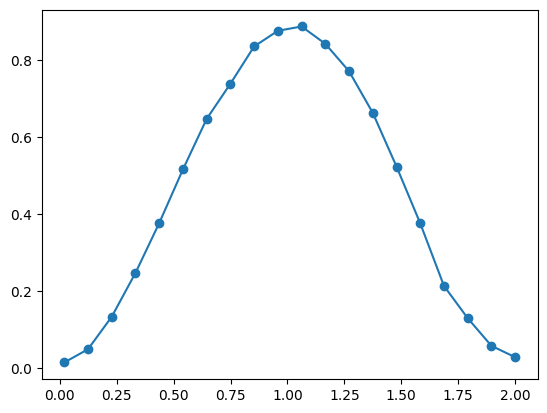

In [32]:
import matplotlib.pyplot as plt
plt.plot(rescaled_env.action(np.linspace(-1.0, 1.0, 20)), np.mean(q_env.reward_history, axis=-1), marker="o")

In [31]:
from qiskit.quantum_info import SparsePauliOp
SparsePauliOp.from_operator(target.dm.to_operator())

SparsePauliOp(['I', 'Z'],
              coeffs=[ 0.5+0.j, -0.5+0.j])

In [26]:
ppo_agent.agent_config.entropy_coef = 0.01

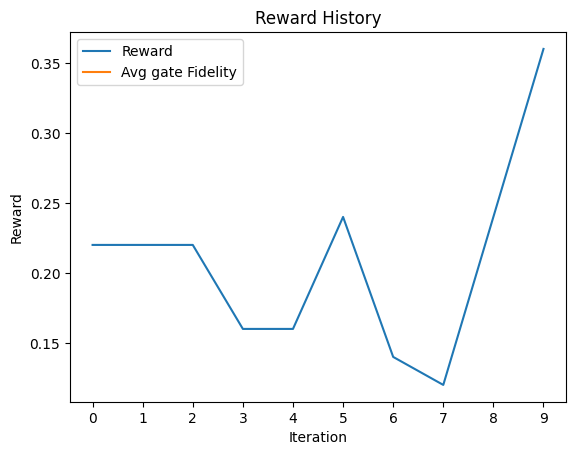

Pushing value [0.32283589243888855] to mu through input stream.


/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/gymnasium/wrappers/utils.py:235: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (obs - intercept) / gradient
/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/rl_qoc/qua/qua_ppo.py:30: RuntimeWarning: overflow encountered in scalar multiply
  return (a * seed + c) % m


Pushing value [0.9988573789596558] to sigma through input stream.
Just pushed policy parameters to OPX: [0.32283589243888855] [0.9988573789596558]
Fetching index: 60, finishing index: 66
Fetching size: 6
Step indices: {1: (0, 6), 2: (6, 12), 3: (12, 18), 4: (18, 24), 5: (24, 30), 6: (30, 36), 7: (36, 42), 8: (42, 48), 9: (48, 54), 10: (54, 60), 11: (60, 66)}
Total data points: 66
Pushing value 6 to max_input_state through input stream.
Pushing value 3 to input_state_0 through input stream.
Pushing value 1 to max_observables through input stream.
Pushing value 400 to pauli_shots through input stream.
Pushing value 1 to observable_0 through input stream.
Pushing value 2 to input_state_0 through input stream.
Pushing value 1 to max_observables through input stream.
Pushing value 400 to pauli_shots through input stream.
Pushing value 1 to observable_0 through input stream.
Pushing value 5 to input_state_0 through input stream.
Pushing value 1 to max_observables through input stream.
Pushin

/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/gymnasium/wrappers/utils.py:235: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (obs - intercept) / gradient
/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/rl_qoc/qua/qua_ppo.py:30: RuntimeWarning: overflow encountered in scalar multiply
  return (a * seed + c) % m


Pushing value [0.995372474193573] to sigma through input stream.
Just pushed policy parameters to OPX: [0.2719210684299469] [0.995372474193573]
Fetching index: 66, finishing index: 72
Fetching size: 6
Step indices: {1: (0, 6), 2: (6, 12), 3: (12, 18), 4: (18, 24), 5: (24, 30), 6: (30, 36), 7: (36, 42), 8: (42, 48), 9: (48, 54), 10: (54, 60), 11: (60, 66), 12: (66, 72)}
Total data points: 72
Pushing value 6 to max_input_state through input stream.
Pushing value 2 to input_state_0 through input stream.
Pushing value 1 to max_observables through input stream.
Pushing value 276 to pauli_shots through input stream.
Pushing value 1 to observable_0 through input stream.
Pushing value 3 to input_state_0 through input stream.
Pushing value 1 to max_observables through input stream.
Pushing value 276 to pauli_shots through input stream.
Pushing value 1 to observable_0 through input stream.
Pushing value 5 to input_state_0 through input stream.
Pushing value 1 to max_observables through input str

QopResponseError: Error from QOP, details:
Job 6efc9c57-43eb-43ce-9b50-d8ffe6295947 was not found.

<Figure size 640x480 with 0 Axes>

In [26]:
results = ppo_agent.train(ppo_training, ppo_settings)

In [53]:
q_env._step_indices

{1: (0, 6), 2: (6, 12)}

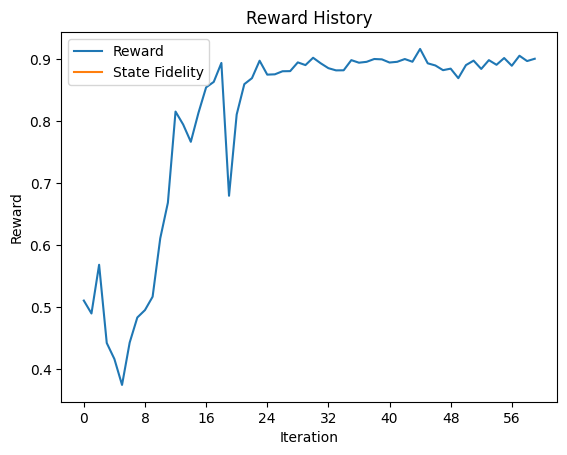

Pushing value [0.4915103316307068] to mu through input stream.


/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/gymnasium/wrappers/utils.py:235: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (obs - intercept) / gradient
/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/rl_qoc/qua/qua_ppo.py:30: RuntimeWarning: overflow encountered in scalar multiply
  return (a * seed + c) % m


Pushing value [0.015455286018550396] to sigma through input stream.
Just pushed policy parameters to OPX: [0.4915103316307068] [0.015455286018550396]
Fetching index: 60, finishing index: 61
Fetching size: 1
Step indices: {1: (0, 1), 2: (1, 2), 3: (2, 3), 4: (3, 4), 5: (4, 5), 6: (5, 6), 7: (6, 7), 8: (7, 8), 9: (8, 9), 10: (9, 10), 11: (10, 11), 12: (11, 12), 13: (12, 13), 14: (13, 14), 15: (14, 15), 16: (15, 16), 17: (16, 17), 18: (17, 18), 19: (18, 19), 20: (19, 20), 21: (20, 21), 22: (21, 22), 23: (22, 23), 24: (23, 24), 25: (24, 25), 26: (25, 26), 27: (26, 27), 28: (27, 28), 29: (28, 29), 30: (29, 30), 31: (30, 31), 32: (31, 32), 33: (32, 33), 34: (33, 34), 35: (34, 35), 36: (35, 36), 37: (36, 37), 38: (37, 38), 39: (38, 39), 40: (39, 40), 41: (40, 41), 42: (41, 42), 43: (42, 43), 44: (43, 44), 45: (44, 45), 46: (45, 46), 47: (46, 47), 48: (47, 48), 49: (48, 49), 50: (49, 50), 51: (50, 51), 52: (51, 52), 53: (52, 53), 54: (53, 54), 55: (54, 55), 56: (55, 56), 57: (56, 57), 58: (57,

/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/gymnasium/wrappers/utils.py:235: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (obs - intercept) / gradient
/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/rl_qoc/qua/qua_ppo.py:30: RuntimeWarning: overflow encountered in scalar multiply
  return (a * seed + c) % m


Pushing value [0.024859361350536346] to sigma through input stream.
Just pushed policy parameters to OPX: [0.5008286833763123] [0.024859361350536346]
Fetching index: 61, finishing index: 62
Fetching size: 1
Step indices: {1: (0, 1), 2: (1, 2), 3: (2, 3), 4: (3, 4), 5: (4, 5), 6: (5, 6), 7: (6, 7), 8: (7, 8), 9: (8, 9), 10: (9, 10), 11: (10, 11), 12: (11, 12), 13: (12, 13), 14: (13, 14), 15: (14, 15), 16: (15, 16), 17: (16, 17), 18: (17, 18), 19: (18, 19), 20: (19, 20), 21: (20, 21), 22: (21, 22), 23: (22, 23), 24: (23, 24), 25: (24, 25), 26: (25, 26), 27: (26, 27), 28: (27, 28), 29: (28, 29), 30: (29, 30), 31: (30, 31), 32: (31, 32), 33: (32, 33), 34: (33, 34), 35: (34, 35), 36: (35, 36), 37: (36, 37), 38: (37, 38), 39: (38, 39), 40: (39, 40), 41: (40, 41), 42: (41, 42), 43: (42, 43), 44: (43, 44), 45: (44, 45), 46: (45, 46), 47: (46, 47), 48: (47, 48), 49: (48, 49), 50: (49, 50), 51: (50, 51), 52: (51, 52), 53: (52, 53), 54: (53, 54), 55: (54, 55), 56: (55, 56), 57: (56, 57), 58: (57,

/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/gymnasium/wrappers/utils.py:235: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (obs - intercept) / gradient
/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/rl_qoc/qua/qua_ppo.py:30: RuntimeWarning: overflow encountered in scalar multiply
  return (a * seed + c) % m


Pushing value [0.023557085543870926] to sigma through input stream.
Just pushed policy parameters to OPX: [0.49830514192581177] [0.023557085543870926]
Fetching index: 62, finishing index: 63
Fetching size: 1
Step indices: {1: (0, 1), 2: (1, 2), 3: (2, 3), 4: (3, 4), 5: (4, 5), 6: (5, 6), 7: (6, 7), 8: (7, 8), 9: (8, 9), 10: (9, 10), 11: (10, 11), 12: (11, 12), 13: (12, 13), 14: (13, 14), 15: (14, 15), 16: (15, 16), 17: (16, 17), 18: (17, 18), 19: (18, 19), 20: (19, 20), 21: (20, 21), 22: (21, 22), 23: (22, 23), 24: (23, 24), 25: (24, 25), 26: (25, 26), 27: (26, 27), 28: (27, 28), 29: (28, 29), 30: (29, 30), 31: (30, 31), 32: (31, 32), 33: (32, 33), 34: (33, 34), 35: (34, 35), 36: (35, 36), 37: (36, 37), 38: (37, 38), 39: (38, 39), 40: (39, 40), 41: (40, 41), 42: (41, 42), 43: (42, 43), 44: (43, 44), 45: (44, 45), 46: (45, 46), 47: (46, 47), 48: (47, 48), 49: (48, 49), 50: (49, 50), 51: (50, 51), 52: (51, 52), 53: (52, 53), 54: (53, 54), 55: (54, 55), 56: (55, 56), 57: (56, 57), 58: (57

/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/gymnasium/wrappers/utils.py:235: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (obs - intercept) / gradient
/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/rl_qoc/qua/qua_ppo.py:30: RuntimeWarning: overflow encountered in scalar multiply
  return (a * seed + c) % m


Pushing value [0.025247447192668915] to sigma through input stream.
Just pushed policy parameters to OPX: [0.4984406530857086] [0.025247447192668915]
Fetching index: 63, finishing index: 64
Fetching size: 1
Step indices: {1: (0, 1), 2: (1, 2), 3: (2, 3), 4: (3, 4), 5: (4, 5), 6: (5, 6), 7: (6, 7), 8: (7, 8), 9: (8, 9), 10: (9, 10), 11: (10, 11), 12: (11, 12), 13: (12, 13), 14: (13, 14), 15: (14, 15), 16: (15, 16), 17: (16, 17), 18: (17, 18), 19: (18, 19), 20: (19, 20), 21: (20, 21), 22: (21, 22), 23: (22, 23), 24: (23, 24), 25: (24, 25), 26: (25, 26), 27: (26, 27), 28: (27, 28), 29: (28, 29), 30: (29, 30), 31: (30, 31), 32: (31, 32), 33: (32, 33), 34: (33, 34), 35: (34, 35), 36: (35, 36), 37: (36, 37), 38: (37, 38), 39: (38, 39), 40: (39, 40), 41: (40, 41), 42: (41, 42), 43: (42, 43), 44: (43, 44), 45: (44, 45), 46: (45, 46), 47: (46, 47), 48: (47, 48), 49: (48, 49), 50: (49, 50), 51: (50, 51), 52: (51, 52), 53: (52, 53), 54: (53, 54), 55: (54, 55), 56: (55, 56), 57: (56, 57), 58: (57,

/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/gymnasium/wrappers/utils.py:235: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (obs - intercept) / gradient
/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/rl_qoc/qua/qua_ppo.py:30: RuntimeWarning: overflow encountered in scalar multiply
  return (a * seed + c) % m


Pushing value [0.016275819391012192] to sigma through input stream.
Just pushed policy parameters to OPX: [0.49250078201293945] [0.016275819391012192]
Fetching index: 64, finishing index: 65
Fetching size: 1
Step indices: {1: (0, 1), 2: (1, 2), 3: (2, 3), 4: (3, 4), 5: (4, 5), 6: (5, 6), 7: (6, 7), 8: (7, 8), 9: (8, 9), 10: (9, 10), 11: (10, 11), 12: (11, 12), 13: (12, 13), 14: (13, 14), 15: (14, 15), 16: (15, 16), 17: (16, 17), 18: (17, 18), 19: (18, 19), 20: (19, 20), 21: (20, 21), 22: (21, 22), 23: (22, 23), 24: (23, 24), 25: (24, 25), 26: (25, 26), 27: (26, 27), 28: (27, 28), 29: (28, 29), 30: (29, 30), 31: (30, 31), 32: (31, 32), 33: (32, 33), 34: (33, 34), 35: (34, 35), 36: (35, 36), 37: (36, 37), 38: (37, 38), 39: (38, 39), 40: (39, 40), 41: (40, 41), 42: (41, 42), 43: (42, 43), 44: (43, 44), 45: (44, 45), 46: (45, 46), 47: (46, 47), 48: (47, 48), 49: (48, 49), 50: (49, 50), 51: (50, 51), 52: (51, 52), 53: (52, 53), 54: (53, 54), 55: (54, 55), 56: (55, 56), 57: (56, 57), 58: (57

QopResponseError: Error from QOP, details:
Job 56f2d472-70cf-4632-acb6-b33ea15b8693 was not found.

<Figure size 640x480 with 0 Axes>

In [26]:
results = ppo_agent.train(ppo_training, ppo_settings)

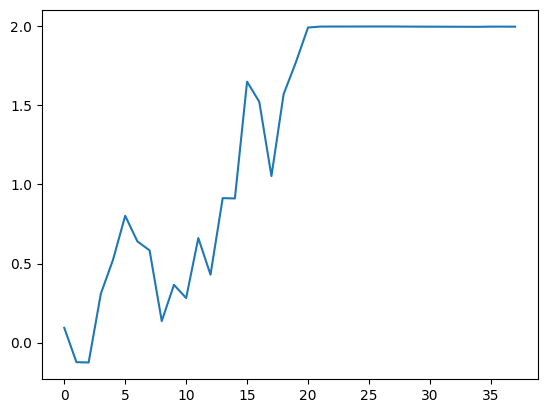

In [29]:
import matplotlib.pyplot as plt
plt.plot(ppo_agent.training_results["clipped_mean_action_0"])
plt.show()

In [30]:
ppo_agent.training_results["mean_action_0"]

[tensor(0.0421),
 tensor(-0.0670),
 tensor(-0.0680),
 tensor(0.1502),
 tensor(0.2582),
 tensor(0.3980),
 tensor(0.3166),
 tensor(0.2881),
 tensor(0.0635),
 tensor(0.1787),
 tensor(0.1367),
 tensor(0.3272),
 tensor(0.2110),
 tensor(0.4541),
 tensor(0.4530),
 tensor(0.8239),
 tensor(0.7603),
 tensor(0.5242),
 tensor(0.7843),
 tensor(0.8850),
 tensor(0.9959),
 tensor(0.9989),
 tensor(0.9991),
 tensor(0.9991),
 tensor(0.9991),
 tensor(0.9992),
 tensor(0.9993),
 tensor(0.9992),
 tensor(0.9989),
 tensor(0.9988),
 tensor(0.9986),
 tensor(0.9986),
 tensor(0.9984),
 tensor(0.9983),
 tensor(0.9982),
 tensor(0.9988),
 tensor(0.9988),
 tensor(0.9986)]

In [32]:
ppo_agent.training_results["std_action_0"]

[tensor(0.5025),
 tensor(0.7355),
 tensor(0.9096),
 tensor(0.9650),
 tensor(0.9930),
 tensor(0.9883),
 tensor(0.9381),
 tensor(0.7993),
 tensor(0.9757),
 tensor(0.9877),
 tensor(0.8978),
 tensor(0.9577),
 tensor(0.8451),
 tensor(0.8511),
 tensor(0.9917),
 tensor(0.9991),
 tensor(0.9969),
 tensor(0.9850),
 tensor(0.9935),
 tensor(0.9963),
 tensor(0.9999),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000)]

In [53]:
ppo_agent.training_results["avg_reward"]

[0.54125,
 0.76,
 0.800625,
 0.8312499999999999,
 0.879375,
 0.8525,
 0.878125,
 0.869375,
 0.9193749999999999,
 0.9168749999999999,
 0.918125,
 0.891875,
 0.8887499999999999,
 0.913125,
 0.875625,
 0.9293749999999998,
 0.890625,
 0.869375,
 0.871875,
 0.9143749999999999,
 0.933125,
 0.8756249999999999,
 0.9231249999999999,
 0.9306249999999999,
 0.866875,
 0.8787499999999999,
 0.89375,
 0.880625,
 0.8574999999999999,
 0.870625,
 0.880625,
 0.8712500000000001,
 0.898125,
 0.8712500000000001,
 0.8512500000000001,
 0.879375,
 0.87625,
 0.891875,
 0.8693749999999999,
 0.9325,
 0.925,
 0.90125,
 0.89,
 0.8925,
 0.86375,
 0.8887499999999999,
 0.893125,
 0.875625,
 0.8743749999999999,
 0.88125,
 0.87375,
 0.8724999999999999,
 0.8674999999999999,
 0.9212499999999999,
 0.894375,
 0.8725,
 0.8731249999999999,
 0.8937499999999999,
 0.88,
 0.8787499999999999,
 0.8993749999999999,
 0.881875,
 0.848125,
 0.9125,
 0.92375,
 0.8668750000000001,
 0.8775,
 0.901875,
 0.934375,
 0.8825000000000001,
 0.88

In [54]:
job.result_handles.reward.fetch_all()

array([([[17, 33], [30, 20], [ 6, 44], [39, 11], [ 9, 41], [27, 23], [15, 35], [ 7, 43], [44,  6], [33, 17], [22, 28], [ 6, 44], [37, 13], [ 7, 43], [49,  1], [38, 12], [13, 37], [22, 28], [44,  6], [21, 29], [41,  9], [32, 18], [10, 40], [15, 35], [27, 23], [33, 17], [46,  4], [14, 36], [10, 40], [13, 37], [ 3, 47], [ 4, 46]],),
       ([[ 5, 45], [ 6, 44], [ 4, 46], [ 6, 44], [ 6, 44], [19, 31], [ 5, 45], [ 4, 46], [49,  1], [10, 40], [13, 37], [ 8, 42], [ 8, 42], [10, 40], [ 6, 44], [26, 24], [32, 18], [ 7, 43], [ 6, 44], [23, 27], [ 8, 42], [11, 39], [21, 29], [ 5, 45], [23, 27], [ 4, 46], [ 3, 47], [27, 23], [ 2, 48], [16, 34], [ 4, 46], [ 7, 43]],),
       ([[ 9, 41], [12, 38], [21, 29], [ 7, 43], [18, 32], [ 4, 46], [40, 10], [ 3, 47], [ 7, 43], [ 8, 42], [ 6, 44], [12, 38], [ 6, 44], [15, 35], [ 6, 44], [14, 36], [ 6, 44], [ 3, 47], [ 8, 42], [ 7, 43], [14, 36], [ 8, 42], [18, 32], [29, 21], [ 8, 42], [11, 39], [ 3, 47], [ 2, 48], [ 5, 45], [ 2, 48], [ 3, 47], [ 4, 46]],),
    

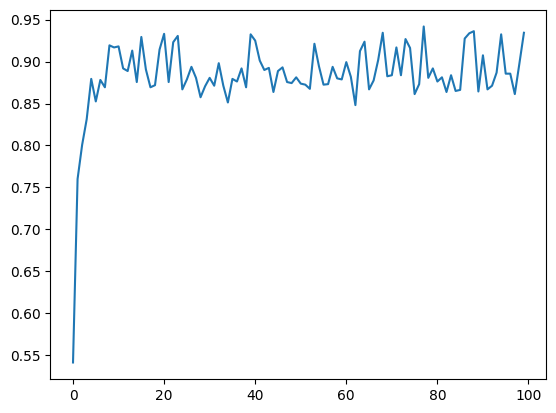

In [55]:
import matplotlib.pyplot as plt
plt.plot(np.mean(q_env.reward_history, axis=-1))

In [28]:
job.status

'completed'

In [56]:
ppo_agent.training_results

{'avg_reward': [0.54125,
  0.76,
  0.800625,
  0.8312499999999999,
  0.879375,
  0.8525,
  0.878125,
  0.869375,
  0.9193749999999999,
  0.9168749999999999,
  0.918125,
  0.891875,
  0.8887499999999999,
  0.913125,
  0.875625,
  0.9293749999999998,
  0.890625,
  0.869375,
  0.871875,
  0.9143749999999999,
  0.933125,
  0.8756249999999999,
  0.9231249999999999,
  0.9306249999999999,
  0.866875,
  0.8787499999999999,
  0.89375,
  0.880625,
  0.8574999999999999,
  0.870625,
  0.880625,
  0.8712500000000001,
  0.898125,
  0.8712500000000001,
  0.8512500000000001,
  0.879375,
  0.87625,
  0.891875,
  0.8693749999999999,
  0.9325,
  0.925,
  0.90125,
  0.89,
  0.8925,
  0.86375,
  0.8887499999999999,
  0.893125,
  0.875625,
  0.8743749999999999,
  0.88125,
  0.87375,
  0.8724999999999999,
  0.8674999999999999,
  0.9212499999999999,
  0.894375,
  0.8725,
  0.8731249999999999,
  0.8937499999999999,
  0.88,
  0.8787499999999999,
  0.8993749999999999,
  0.881875,
  0.848125,
  0.9125,
  0.92375,

In [44]:
from torch.distributions import Normal
import torch
ppo_agent.process_action(Normal(0.1221*torch.ones((32,)), 0.50*torch.ones((32,))))

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [45]:
q_env.reward_history

[array([0.  , 0.  , 0.02, 0.02, 0.  , 0.  , 0.02, 0.02, 0.02, 0.02, 0.  ,
        0.02, 0.  , 0.02, 0.  , 0.  , 0.04, 0.02, 0.04, 0.  , 0.02, 0.04,
        0.02, 0.  , 0.02, 0.  , 0.04, 0.  , 0.02, 0.04, 0.02, 0.  ]),
 array([0.04, 0.04, 0.02, 0.02, 0.06, 0.02, 0.04, 0.04, 0.04, 0.04, 0.1 ,
        0.06, 0.1 , 0.04, 0.06, 0.04, 0.04, 0.06, 0.04, 0.1 , 0.06, 0.06,
        0.06, 0.04, 0.06, 0.04, 0.1 , 0.02, 0.  , 0.08, 0.02, 0.04]),
 array([0.14, 0.12, 0.18, 0.04, 0.2 , 0.18, 0.16, 0.14, 0.12, 0.16, 0.04,
        0.12, 0.12, 0.14, 0.14, 0.22, 0.14, 0.16, 0.14, 0.12, 0.2 , 0.12,
        0.1 , 0.24, 0.08, 0.14, 0.14, 0.04, 0.18, 0.08, 0.08, 0.1 ]),
 array([0.12, 0.34, 0.36, 0.34, 0.22, 0.3 , 0.26, 0.22, 0.36, 0.18, 0.3 ,
        0.22, 0.42, 0.18, 0.22, 0.22, 0.2 , 0.26, 0.24, 0.34, 0.26, 0.12,
        0.26, 0.24, 0.26, 0.18, 0.14, 0.28, 0.26, 0.14, 0.22, 0.26]),
 array([0.34, 0.42, 0.32, 0.28, 0.38, 0.44, 0.34, 0.38, 0.42, 0.46, 0.38,
        0.38, 0.4 , 0.28, 0.38, 0.32, 0.42, 0.32, 0.3 

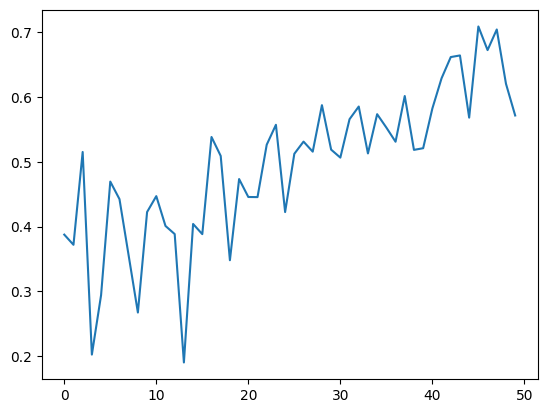

In [30]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.mean(q_env.reward_history, axis=-1))
plt.show()

In [32]:
results

{'avg_reward': [0.38756250000000003,
  0.371875,
  0.5150625,
  0.2025,
  0.2941875,
  0.469375,
  0.4423125,
  0.3550625,
  0.26737500000000003,
  0.4224375,
  0.4469375,
  0.4009375,
  0.3884375,
  0.19031250000000002,
  0.404,
  0.3883125,
  0.5381875,
  0.509,
  0.34806250000000005,
  0.4733125,
  0.445625,
  0.4454375,
  0.52625,
  0.5569999999999999,
  0.42237499999999994,
  0.51225,
  0.5310625,
  0.5155625,
  0.5873125,
  0.5186875,
  0.5063749999999999,
  0.5656249999999999,
  0.5851875,
  0.5128125,
  0.573375,
  0.5527500000000001,
  0.530875,
  0.6014375000000001,
  0.5183125,
  0.520875,
  0.582125,
  0.6287499999999999,
  0.6615,
  0.664,
  0.5680624999999999,
  0.7086874999999999,
  0.67225,
  0.7040625,
  0.6203125,
  0.571375],
 'fidelity_history': [],
 'hardware_runtime': [0.11352600000000002,
  0.11352600000000002,
  0.11352600000000002,
  0.11352600000000002,
  0.11352600000000002,
  0.11352600000000002,
  0.11352600000000002,
  0.11352600000000002,
  0.113526000000

In [46]:
ppo_agent.env.unwrapped.reward_history

[array([0.  , 0.  , 0.02, 0.02, 0.  , 0.  , 0.02, 0.02, 0.02, 0.02, 0.  ,
        0.02, 0.  , 0.02, 0.  , 0.  , 0.04, 0.02, 0.04, 0.  , 0.02, 0.04,
        0.02, 0.  , 0.02, 0.  , 0.04, 0.  , 0.02, 0.04, 0.02, 0.  ]),
 array([0.04, 0.04, 0.02, 0.02, 0.06, 0.02, 0.04, 0.04, 0.04, 0.04, 0.1 ,
        0.06, 0.1 , 0.04, 0.06, 0.04, 0.04, 0.06, 0.04, 0.1 , 0.06, 0.06,
        0.06, 0.04, 0.06, 0.04, 0.1 , 0.02, 0.  , 0.08, 0.02, 0.04]),
 array([0.14, 0.12, 0.18, 0.04, 0.2 , 0.18, 0.16, 0.14, 0.12, 0.16, 0.04,
        0.12, 0.12, 0.14, 0.14, 0.22, 0.14, 0.16, 0.14, 0.12, 0.2 , 0.12,
        0.1 , 0.24, 0.08, 0.14, 0.14, 0.04, 0.18, 0.08, 0.08, 0.1 ]),
 array([0.12, 0.34, 0.36, 0.34, 0.22, 0.3 , 0.26, 0.22, 0.36, 0.18, 0.3 ,
        0.22, 0.42, 0.18, 0.22, 0.22, 0.2 , 0.26, 0.24, 0.34, 0.26, 0.12,
        0.26, 0.24, 0.26, 0.18, 0.14, 0.28, 0.26, 0.14, 0.22, 0.26]),
 array([0.34, 0.42, 0.32, 0.28, 0.38, 0.44, 0.34, 0.38, 0.42, 0.46, 0.38,
        0.38, 0.4 , 0.28, 0.38, 0.32, 0.42, 0.32, 0.3 

In [ ]:
q_env.policy.push_to_opx({"mu": [1.0], "sigma": [0.2]}, job, verbosity=2)

In [ ]:
q_env.max_input_state.push_to_opx(1, job, verbosity=2)

In [ ]:
q_env.input_state_vars.push_to_opx({"input_state_0": 1}, job, verbosity=2)

In [ ]:
q_env.qm_backend_config

In [ ]:
q_env.mean_action

In [ ]:
print(job.result_handles.reward.fetch_all()["value"])

In [69]:
results = job.result_handles.reward.fetch_all()["value"]

In [29]:
job.result_handles.a_0_0.fetch_all()

array([(0.77628107,), (1.20599005,), (1.79058975,), ..., (1.77650536,),
       (2.        ,), (2.        ,)],
      shape=(2976,), dtype=[('value', '<f8')])

In [71]:
results

array([[[479,  21],
        [476,  24]],

       [[458,  42],
        [454,  46]],

       [[392, 108],
        [376, 124]],

       [[312, 188],
        [308, 192]],

       [[203, 297],
        [197, 303]],

       [[119, 381],
        [139, 361]],

       [[ 63, 437],
        [ 56, 444]],

       [[ 32, 468],
        [ 36, 464]],

       [[ 39, 461],
        [ 51, 449]],

       [[109, 391],
        [ 97, 403]],

       [[178, 322],
        [187, 313]],

       [[283, 217],
        [277, 223]],

       [[378, 122],
        [366, 134]],

       [[445,  55],
        [445,  55]],

       [[472,  28],
        [470,  30]],

       [[476,  24],
        [476,  24]],

       [[435,  65],
        [417,  83]],

       [[357, 143],
        [370, 130]],

       [[271, 229],
        [268, 232]],

       [[170, 330],
        [163, 337]],

       [[ 97, 403],
        [ 84, 416]],

       [[ 53, 447],
        [ 51, 449]],

       [[ 41, 459],
        [ 48, 452]],

       [[ 59, 441],
        [ 85, 

In [79]:
from qiskit.primitives import BitArray
counts = []
reward_array = np.zeros(shape=(q_env.config.batch_size,))
reward_data = q_env.reward_data
config = q_env.config
formatted_counts = []
collected_counts = results
count_idx = 0
num_qubits = q_env.config.target.causal_cone_size if isinstance(q_env.config.target, GateTarget) else q_env.config.target.n_qubits
dim = 2**num_qubits
binary = lambda n, l: bin(n)[2:].zfill(l)
num_obs = len(reward_data.observables_indices[0])
for o_idx in range(num_obs):
    formatted_counts.append([])
    counts_array = np.array(collected_counts[count_idx], dtype=int)
    formatted_counts[o_idx] = counts_array
    count_idx += 1
for batch_idx in range(config.batch_size):
    counts.append([])
    for o_idx in range(num_obs):
        counts[batch_idx].append(formatted_counts[o_idx][batch_idx])

for batch_idx in range(config.batch_size):
    exp_value = reward_data.id_coeff
    for o_idx in range(num_obs):
        counts_dict = {
            binary(i, num_qubits): int(counts[batch_idx][o_idx][i]) for i in range(dim)
        }
        obs = reward_data[0].observables.group_commuting(True)[o_idx]
        diag_obs = SparsePauliOp("I" * num_qubits, 0.0)
        for obs_, coeff in zip(obs.paulis, obs.coeffs):
            diag_obs_label = ""
            for char in obs_.to_label():
                diag_obs_label += char if char == "I" else "Z"
            diag_obs += SparsePauliOp(diag_obs_label, coeff)
        bit_array = BitArray.from_counts(counts_dict, num_bits=num_qubits)
        exp_value += bit_array.expectation_values(diag_obs.simplify())
    
    exp_value /= reward_data.pauli_sampling
    reward_array[batch_idx] = exp_value

In [83]:
counts

[[array([479,  21])], [array([476,  24])]]

In [45]:
reshaped_counts = []
for batch_idx in range(q_env.batch_size):
    reshaped_counts.append([])
    for i_idx in range(max_input_state):
        reshaped_counts[batch_idx].append([])
        for o_idx in range(num_obs_per_input_state[i_idx]):

            reshaped_counts[batch_idx][i_idx].append(
                formatted_counts[i_idx][o_idx][batch_idx]
            )

In [46]:
reshaped_counts

[[[array([1948,   52])]], [[array([1950,   50])]]]

In [ ]:
from qiskit.quantum_info import Statevector
Statevector.from_label("0").expectation_value(q_env.reward_data.hamiltonian/q_env.reward_data.pauli_sampling)

In [ ]:
q_env.reward_data.pauli_sampling

In [ ]:
q_env.reward_data[0].precision

In [ ]:
from torch.distributions import Normal
import torch
ppo_agent.process_action(Normal(ppo_agent.agent(torch.zeros((q_env.batch_size,2)))[0].detach(),ppo_agent.agent(torch.zeros((q_env.batch_size,2)))[1].detach() ))

In [49]:
q_env.reward_data.hamiltonian

SparsePauliOp(['I', 'Z'],
              coeffs=[ 4.+0.j, -6.+0.j])

In [ ]:
q_env.reward_data.id_coeff/20

In [47]:
from rl_qoc.qua.qua_utils import binary
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import BitArray
reward = np.zeros(q_env.batch_size)
dim = 2**q_env.n_qubits
counts = reshaped_counts
for batch_idx in range(q_env.batch_size):
    exp_value = q_env.reward_data.id_coeff
    for i_idx in range(max_input_state):
        for o_idx in range(num_obs_per_input_state[i_idx]):
            counts_dict = {
                binary(i, q_env.n_qubits): counts[batch_idx][i_idx][o_idx][i]
                for i in range(dim)
            }
            print(counts_dict)
            obs = q_env.reward_data[i_idx].hamiltonian.group_commuting(True)[o_idx]
            print(obs)
            diag_obs = SparsePauliOp("I" * q_env.n_qubits, 0.0)
            for obs_, coeff in zip(obs.paulis, obs.coeffs):
                diag_obs_label = ""
                for char in obs_.to_label():
                    diag_obs_label += char if char == "I" else "Z"
                diag_obs += SparsePauliOp(diag_obs_label, coeff)
            bit_array = BitArray.from_counts(counts_dict, num_bits=q_env.n_qubits)
            print(diag_obs.simplify())
            exp_value += bit_array.expectation_values(diag_obs.simplify())
    exp_value /= q_env.reward_data.pauli_sampling
    reward[batch_idx] = exp_value

{'0': np.int64(1948), '1': np.int64(52)}
SparsePauliOp(['I', 'Z'],
              coeffs=[ 4.+0.j, -6.+0.j])
SparsePauliOp(['I', 'Z'],
              coeffs=[ 4.+0.j, -6.+0.j])
{'0': np.int64(1950), '1': np.int64(50)}
SparsePauliOp(['I', 'Z'],
              coeffs=[ 4.+0.j, -6.+0.j])
SparsePauliOp(['I', 'Z'],
              coeffs=[ 4.+0.j, -6.+0.j])


In [48]:
reward

array([0.2312, 0.23  ])

In [ ]:
job.result_handles.reward.fetch_all()["value"].shape

In [ ]:
counts = np.transpose(job.result_handles.reward.fetch_all()["value"], (1, 0, 2))

In [ ]:
from rl_qoc.qua.qua_utils import binary
from qiskit.primitives import BitArray

reward = np.zeros(q_env.batch_size)
for b in range(q_env.batch_size):
    sv = np.zeros(4)
    for i_idx in range(4):
        counts_dict = {binary(i, 1): counts[b, i_idx, i] for i in range(2)}
        bit_array = BitArray.from_counts(counts_dict, num_bits=1)
        sv[i_idx] = bit_array.get_int_counts().get(0, 0) / q_env.n_shots
    reward[b] = np.mean(sv)

reward

In [ ]:
-np.log10(1.0 - reward)

In [ ]:
print(job.result_handles.action.fetch_all())

In [ ]:
q_env._step_indices

In [ ]:
job.result_handles.reward.count_so_far()

In [ ]:
q_env._total_data_points

In [ ]:
job.status

In [ ]:
q_env.close()

In [ ]:
from qm.qua import *

with program() as qua_program:
    gate = declare_input_stream(fixed, name="gate_input_stream")

    a = declare(fixed)
    r1 = declare_stream()
    r2 = declare_stream()
    v2 = declare(
        bool,
    )
    advance_input_stream(gate)
    with while_(gate > 0):
        a = gate
        save(a, r1)
        assign(v2, (a > 0.2))
        save(v2, r2)
        advance_input_stream(gate)

    with stream_processing():
        r1.save_all("measurements")
        r2.save_all("state")

job = backend.qm.execute(qua_program)

In [ ]:
result = job.result_handles

optimization_sequence = [0.1, 0.4, 0.06]

for id, value in enumerate(optimization_sequence):
    job.push_to_input_stream("gate_input_stream", value)
    result.measurements.wait_for_values(id + 1)
    print("Full data", str(result.measurements.fetch_all()))
    print(f"{id}: Received ", str(result.measurements.fetch(id)))
    result.state.wait_for_values(id + 1)
    print(f"{id}: Received ", str(result.state.fetch(id)))
    print("Full data", str(result.state.fetch_all()))

# finish QUA program
job.push_to_input_stream("gate_input_stream", 0)

In [ ]:
# Single QUA script generated at 2025-06-09 11:30:49.218366
# QUA library version: 1.2.3a1

from qm import CompilerOptionArguments
from qm.qua import *

with program() as prog:
    a1 = declare(fixed, value=[0.0])
    v1 = declare(
        int,
    )
    a2 = declare(fixed, value=[1.0])
    v2 = declare(
        int,
    )
    v3 = declare(int, value=0)
    v4 = declare(
        int,
    )
    v5 = declare(
        int,
    )
    with for_(v5, 0, (v5 < 5), (v5 + 1)):
        pause()
        assign(a1[0], IO1)
        r1 = declare_stream()
        save(a1[0], r1)
    with stream_processing():
        r1.save_all("mu")


config = None

loaded_config = None


job = backend.qm.execute(prog)

In [ ]:
job.is_paused()

In [ ]:
backend.qm.set_io1_value(1.0)

In [ ]:
job.resume()

In [ ]:
job.is_paused()

In [ ]:
print(job.result_handles.mu.fetch_all())

In [ ]:
job.cancel()

In [ ]:
job.is_paused()

In [ ]:
print(job.result_handles.mu.fetch_all())

In [ ]:
job.cancel()